<a href="https://colab.research.google.com/github/uroy98/ARES_Vidura/blob/main/EmotionDetect_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Code for predicting emotion based on EEG data

Class Distribution Before Balancing:
label_encoded
1    716
0    708
2    708
Name: count, dtype: int64

Class Distribution After Balancing:
label_encoded
0    716
1    716
2    716
Name: count, dtype: int64

Explained variance ratio (first 5 components): [0.36862157 0.09576584 0.0847872  0.06039865 0.04708886]

Starting hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:04:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Hyperparameter tuning completed in 33.33 seconds.

Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

Classification Report:

              precision    recall  f1-score   support

       Happy       0.94      0.97      0.96       134
     Neutral       0.98      0.99      0.99       142
         Sad       0.97      0.94      0.95       154

    accuracy                           0.97       430
   macro avg       0.96      0.97      0.97       430
weighted avg       0.97      0.97      0.97       430


Misclassified Samples:
    Predicted Emotion True Emotion
3               Happy          Sad
13              Happy          Sad
27                Sad        Happy
109               Sad        Happy
134           Neutral          Sad
173             Happy          Sad
182             Happy          Sad
185               Sad        Happy
258             Happy          Sad
274          

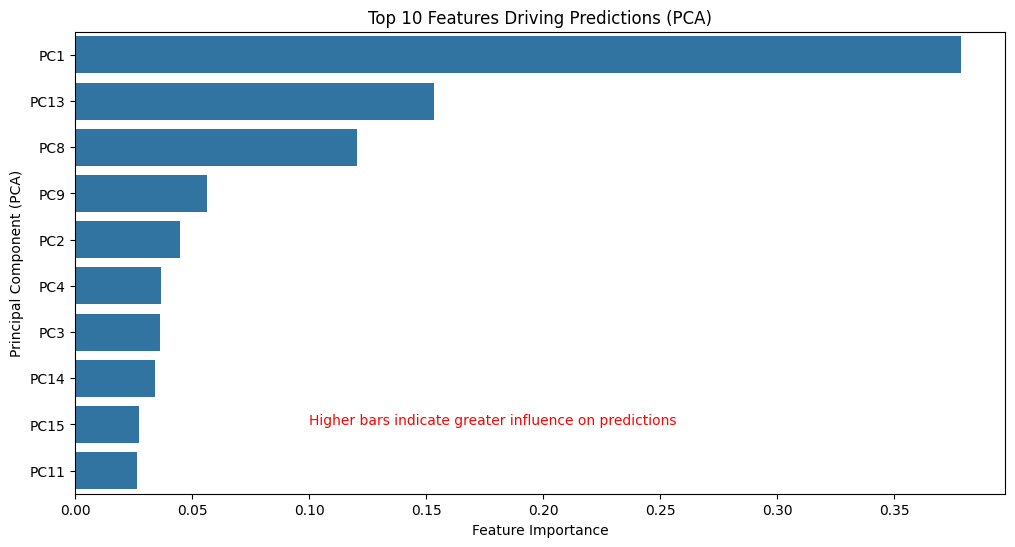


Top Features Contributing to PC1:
mean_2_a       0.032361
mean_2_b       0.032255
mean_d_2_b2    0.032063
mean_d_12_a    0.032055
mean_d_7_b     0.032014
mean_d_17_a    0.032012
mean_d_7_a     0.031602
mean_d_12_b    0.031377
mean_d_2_a2    0.030889
mean_d_17_b    0.030683
Name: PC1, dtype: float64


'\n# SHAP Analysis for Misclassified Samples\nexplainer = shap.TreeExplainer(best_xgb_clf)\nshap_values = explainer.shap_values(X_test)  # SHAP values for multi-class\n\nif not misclassified.empty:\n    misclassified.reset_index(inplace=True)\n    \n    for idx, row in misclassified.iterrows():\n        sample_idx = row[\'index\']  # Original sample index\n        predicted_class_idx = reverse_emotion_mapping[row[\'Predicted Emotion\']]\n        true_class_idx = reverse_emotion_mapping[row[\'True Emotion\']]\n        \n        print(f"\nExplaining prediction for misclassified sample at index {sample_idx}...")\n        print(f"True Emotion: {row[\'True Emotion\']}, Predicted Emotion: {row[\'Predicted Emotion\']}")\n\n        shap.initjs()\n        # Add a SHAP force plot for the misclassified sample\n        shap.force_plot(\n            explainer.expected_value[predicted_class_idx],\n            shap_values[predicted_class_idx][sample_idx],\n            X_test[sample_idx],\n           

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time  # For tracking time

# Load Dataset
file_path = '/content/emotions.csv'
data = pd.read_csv(file_path)

# Encode Target Variable
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

# Check Class Distribution
class_counts = data['label_encoded'].value_counts()
print("Class Distribution Before Balancing:")
print(class_counts)

# Split Features and Target
X = data.drop(columns=['label', 'label_encoded'])
y = data['label_encoded']

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE for Oversampling Minority Classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Check Balanced Class Distribution
balanced_class_counts = pd.Series(y_balanced).value_counts()
print("\nClass Distribution After Balancing:")
print(balanced_class_counts)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=15)  # Experiment with fewer components
X_pca = pca.fit_transform(X_balanced)

# Print PCA variance ratios
print(f"\nExplained variance ratio (first 5 components): {pca.explained_variance_ratio_[:5]}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_balanced, test_size=0.2, random_state=42)

# Reduced Parameter Grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3]
}

# RandomizedSearchCV for Hyperparameter Tuning
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss"),
    param_distributions=param_grid,
    n_iter=20,  # Test fewer combinations for faster execution
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
print("\nStarting hyperparameter tuning...")
random_search.fit(X_train, y_train)
print(f"\nHyperparameter tuning completed in {time.time() - start_time:.2f} seconds.")

# Best Model
best_xgb_clf = random_search.best_estimator_
print("\nBest Parameters:", random_search.best_params_)

# Evaluate Best Model
y_pred = best_xgb_clf.predict(X_test)

# Define a dictionary to map label encodings back to emotions
emotion_mapping = {
    0: "Happy",
    1: "Neutral",
    2: "Sad"
}
reverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}

# Convert predictions and true labels to human-readable emotions
y_pred_emotions = [emotion_mapping[label] for label in y_pred]
y_test_emotions = [emotion_mapping[label] for label in y_test]

# Display classification report with readable emotions
print("\nClassification Report:\n")
print(classification_report(y_test_emotions, y_pred_emotions))

# Misclassified Samples
comparison_df = pd.DataFrame(X_test, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
comparison_df['True Emotion'] = y_test_emotions
comparison_df['Predicted Emotion'] = y_pred_emotions

# Filter misclassified samples
misclassified = comparison_df[comparison_df['True Emotion'] != comparison_df['Predicted Emotion']]
print("\nMisclassified Samples:")
print(misclassified[['Predicted Emotion', 'True Emotion']])

# Visualize Feature Importances
feature_importance = pd.DataFrame({
    'Feature': [f'PC{i+1}' for i in range(X_pca.shape[1])],
    'Importance': best_xgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Top 10 Features with Annotations
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature')
plt.title('Top 10 Features Driving Predictions (PCA)')
plt.xlabel("Feature Importance")
plt.ylabel("Principal Component (PCA)")
plt.annotate("Higher bars indicate greater influence on predictions", (0.1, 8), fontsize=10, color="red")
plt.show()

# Map PCA Components to Original Features
pca_components = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i+1}' for i in range(15)])
pc1_contributions = pca_components.loc['PC1'].sort_values(ascending=False)
print("\nTop Features Contributing to PC1:")
print(pc1_contributions.head(10))

'''
# SHAP Analysis for Misclassified Samples
explainer = shap.TreeExplainer(best_xgb_clf)
shap_values = explainer.shap_values(X_test)  # SHAP values for multi-class

if not misclassified.empty:
    misclassified.reset_index(inplace=True)

    for idx, row in misclassified.iterrows():
        sample_idx = row['index']  # Original sample index
        predicted_class_idx = reverse_emotion_mapping[row['Predicted Emotion']]
        true_class_idx = reverse_emotion_mapping[row['True Emotion']]

        print(f"\nExplaining prediction for misclassified sample at index {sample_idx}...")
        print(f"True Emotion: {row['True Emotion']}, Predicted Emotion: {row['Predicted Emotion']}")

        shap.initjs()
        # Add a SHAP force plot for the misclassified sample
        shap.force_plot(
            explainer.expected_value[predicted_class_idx],
            shap_values[predicted_class_idx][sample_idx],
            X_test[sample_idx],
            feature_names=[f'PC{i+1}' for i in range(X_pca.shape[1])]
        )
else:
    print("\nNo misclassified samples to analyze with SHAP.")

'''

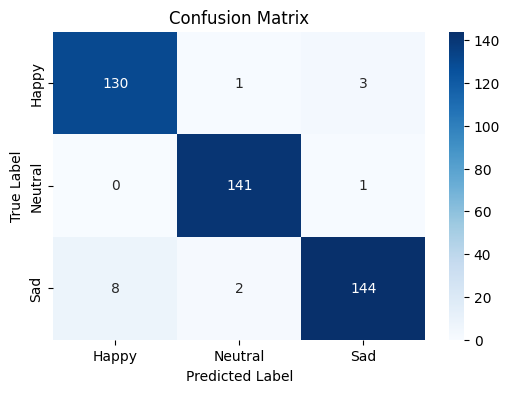

In [ ]:
# Compute the confusion matrix using the human-readable labels
cm = confusion_matrix(y_test_emotions, y_pred_emotions, labels=["Happy", "Neutral", "Sad"])

# Set up the plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Happy", "Neutral", "Sad"],
            yticklabels=["Happy", "Neutral", "Sad"])

# Add labels and title to the plot
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import joblib

# Save the trained best model to a file
model_filename = "best_xgb_clf.pkl"
joblib.dump(best_xgb_clf, model_filename)
print(f"Model saved to {model_filename}")

# Display the test data (X_test) for further use
print("\nX_test for model inference:")
print(X_test)


Model saved to best_xgb_clf.pkl

X_test for model inference:
[[ -6.07008032  17.47827396  -4.00004335 ...   0.55032787   0.34712033
   -0.68451151]
 [  6.04529526  10.95800183 -11.49475053 ...  -2.66839232  -1.13397851
    0.32308717]
 [ 21.77969484   3.35184941  -1.60109962 ...  -0.96231001  -0.60773074
    1.14136689]
 ...
 [-38.22561595 -35.13400564 -11.91508944 ...  -0.42187262   0.91439838
    2.27636787]
 [-12.30730743 -31.37461679 -10.94726021 ...  -1.8394059   -2.01395855
   -0.22365885]
 [ 21.87096662   2.99595268  -1.49645886 ...  -2.2661173   -0.64130913
   -0.3243701 ]]


In [ ]:
import pandas as pd

# Convert X_test into a DataFrame with column names matching the PCA components
X_test_df = pd.DataFrame(X_test, columns=[f'PC{i+1}' for i in range(X_test.shape[1])])

# Save the DataFrame to a CSV file
csv_filename = "X_test.csv"
X_test_df.to_csv(csv_filename, index=False)
print(f"X_test has been saved to {csv_filename}")


X_test has been saved to X_test.csv


In [ ]:
# Ensure y_test has the desired name
y_test.name = "y_test"

# Save y_test to a CSV file without the index
y_test.to_csv("y_test.csv", index=False)
print("y_test has been saved to y_test.csv with header 'y_test'")


y_test has been saved to y_test.csv with header 'y_test'


Model loaded from best_xgb_clf.pkl
X_test loaded successfully. Shape: (430, 15)
y_test loaded successfully. Here's a preview:
   y_test
0       0
1       2
2       1
3       2
4       0
y_test_loaded shape: (430,)
y_pred shape: (430,)
Number of true labels: 430
Number of predicted labels: 430


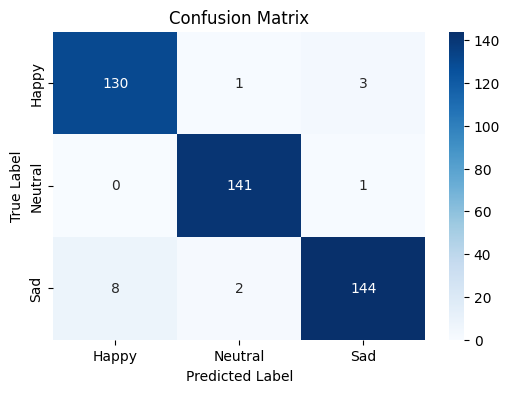

In [ ]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the saved model
model_filename = "best_xgb_clf.pkl"
model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

# Load X_test from CSV
X_test_loaded = pd.read_csv("X_test.csv")
print("X_test loaded successfully. Shape:", X_test_loaded.shape)

# Load the corresponding true labels (y_test) from CSV
y_test_df = pd.read_csv("y_test.csv")  # Make sure the CSV has a header or adjust accordingly
print("y_test loaded successfully. Here's a preview:")
print(y_test_df.head())

# If the CSV contains only one column, convert it to a 1D array
y_test_loaded = y_test_df.iloc[:, 0].values
print("y_test_loaded shape:", y_test_loaded.shape)

# Make predictions using the loaded model
y_pred = model.predict(X_test_loaded)
print("y_pred shape:", y_pred.shape)

# Define a dictionary to map label encodings back to emotions
emotion_mapping = {
    0: "Happy",
    1: "Neutral",
    2: "Sad"
}

# Convert predictions and true labels to human-readable emotions
try:
    y_pred_emotions = [emotion_mapping[label] for label in y_pred]
    y_test_emotions = [emotion_mapping[label] for label in y_test_loaded]
except KeyError as e:
    print("Key error in mapping:", e)
    print("Unique values in y_test_loaded:", set(y_test_loaded))
    raise e

# Debug: Print lengths to ensure they match
print("Number of true labels:", len(y_test_emotions))
print("Number of predicted labels:", len(y_pred_emotions))

# Compute the confusion matrix
cm = confusion_matrix(y_test_emotions, y_pred_emotions)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Happy", "Neutral", "Sad"],
            yticklabels=["Happy", "Neutral", "Sad"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


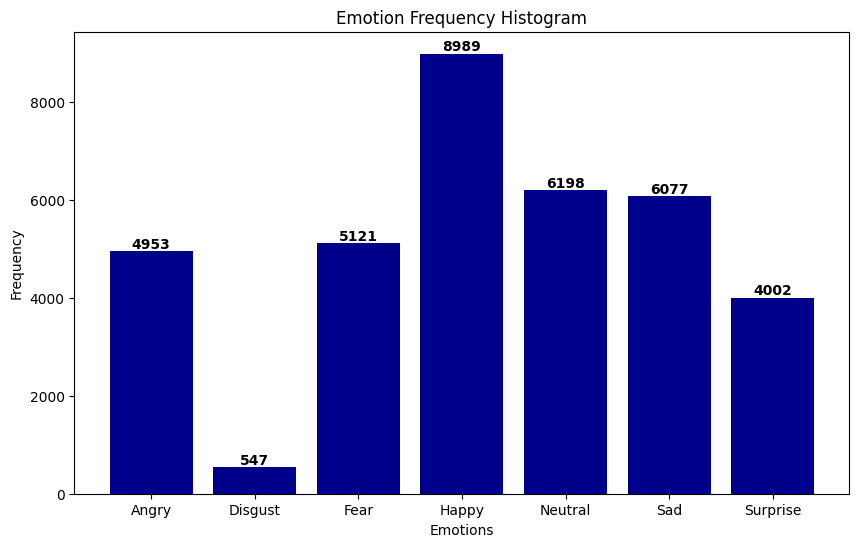

In [2]:
import matplotlib.pyplot as plt

# Define emotion counts by summing the given values
emotions = {
    'Angry': 3995 + 958,
    'Disgust': 436 + 111,
    'Fear': 4097 + 1024,
    'Happy': 1774 + 7215,
    'Neutral': 1233 + 4965,
    'Sad': 4830 + 1247,
    'Surprise': 831 + 3171
}

# Extract labels and their corresponding frequencies
labels = list(emotions.keys())
frequencies = list(emotions.values())

# Create a bar chart (histogram) for the emotion frequencies
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, frequencies, color='darkblue')

# Annotate each bar with its frequency value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height}', ha='center', va='bottom', fontweight='bold')

plt.xlabel("Emotions")
plt.ylabel("Frequency")
plt.title("Emotion Frequency Histogram")
plt.show()
